In [32]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import clear_output

import random
random.seed(56)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
plt.rc("font", family="Malgun Gothic")
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline
from datetime import datetime as dt
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm 
import lightgbm
import optuna
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

## Dataset

In [43]:
# 학습 데이터
train = pd.read_csv('./train.csv')
train

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 제품 품질 상태(Target) (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)
* Y_Quality : 제품 품질 수치
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [44]:
# 검증 데이터
test = pd.read_csv('./test.csv')
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 2:01,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 2:09,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 8:42,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* PRODUCT_ID : 제품의 고유 ID
* TIMESTAMP : 제품이 공정에 들어간 시각
* LINE : 제품이 들어간 공정 LINE 종류 ('T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305' 존재)
* PRODUCT_CODE : 제품의 CODE 번호 ('A_31', 'T_31', 'O_31' 존재)
* X_1 ~ X_2875 : 공정 과정에서 추출되어 비식별화된 변수

In [45]:
# 제출 양식
subm = pd.read_csv('./sample_submission.csv')
subm.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


* PRODUCT_ID : 제품의 고유 ID
* Y_Class : 예측한 제품 품질 상태 (0 : 기준 미달, 1 : 적합, 2 : 기준 초과)

### dtypes

In [46]:
train.dtypes

PRODUCT_ID     object
Y_Class         int64
Y_Quality     float64
TIMESTAMP      object
LINE           object
               ...   
X_2871        float64
X_2872        float64
X_2873        float64
X_2874        float64
X_2875        float64
Length: 2881, dtype: object

In [47]:
train['LINE'] = train['LINE'].astype('category')
train['PRODUCT_CODE'] = train['PRODUCT_CODE'].astype('category')

### Y Class & Y Quality

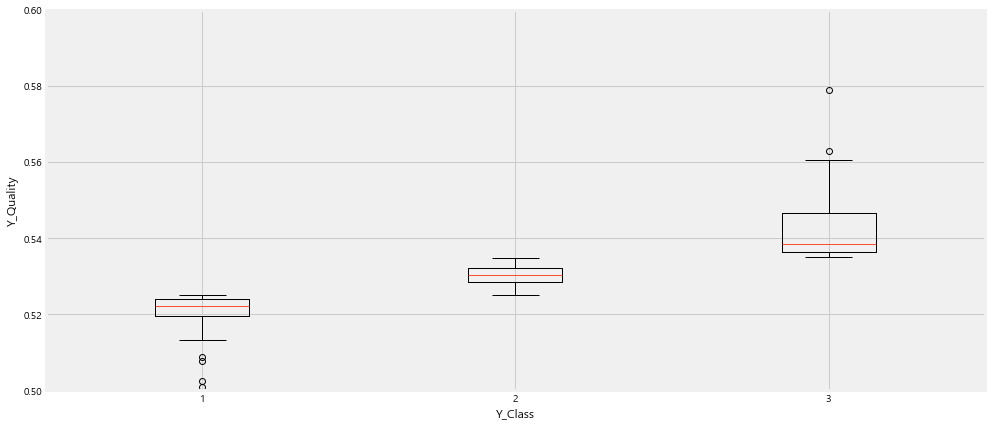

In [48]:
rcParams['figure.figsize'] = 15, 7

fig, ax = plt.subplots()

ax.boxplot([train[train['Y_Class']==0].Y_Quality, train[train['Y_Class']==1].Y_Quality, train[train['Y_Class']==2].Y_Quality])
ax.set_ylim(0.5, 0.6)
ax.set_xlabel('Y_Class')
ax.set_ylabel('Y_Quality')
plt.show()

In [49]:
# Class는 Quality를 3등분한 결과
for i in range(3):
    tmp = train[train['Y_Class']==i].Y_Quality
    print(f'Class : {i}, Quality range : {min(tmp)} ~ {max(tmp)}')

Class : 0, Quality range : 0.500855556 ~ 0.525066667
Class : 1, Quality range : 0.525085714 ~ 0.534842857
Class : 2, Quality range : 0.534950794 ~ 0.57884127


In [50]:
train.Y_Class.value_counts()

1    407
2    103
0     88
Name: Y_Class, dtype: int64

### Product Code

In [51]:
# Product Code는 3가지로 이루어져 있다.
train['PRODUCT_CODE'].value_counts()

T_31    343
A_31    249
O_31      6
Name: PRODUCT_CODE, dtype: int64

### Line

In [52]:
# Line은 6가지
train['LINE'].value_counts()

T100304    175
T100306    174
T050304     78
T010306     70
T010305     59
T050307     42
Name: LINE, dtype: int64

### TimeStamp

* 일, 시, 분 단위 모두 연속적이지 않으므로 활용할 수 없다. interpolate(보간)을 하기에도 너무 공백이 많다.
* 단 월 단위는 quality의 감소세가 확인된다.

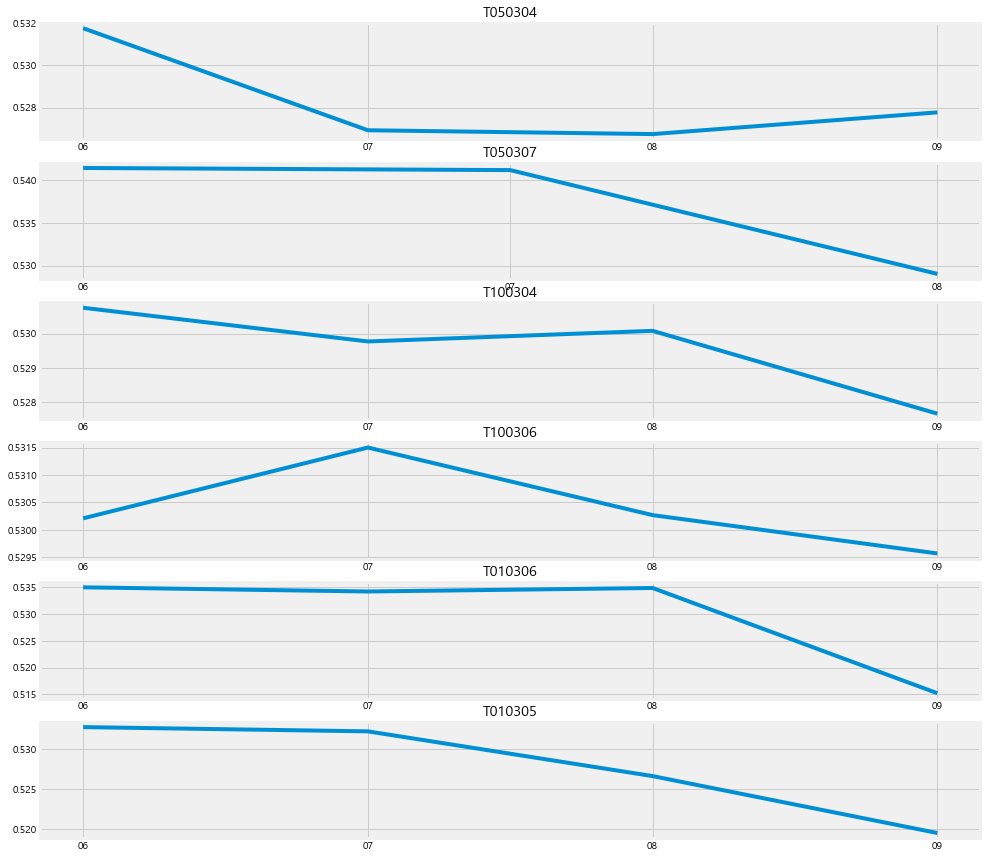

In [53]:
# LINE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['LINE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

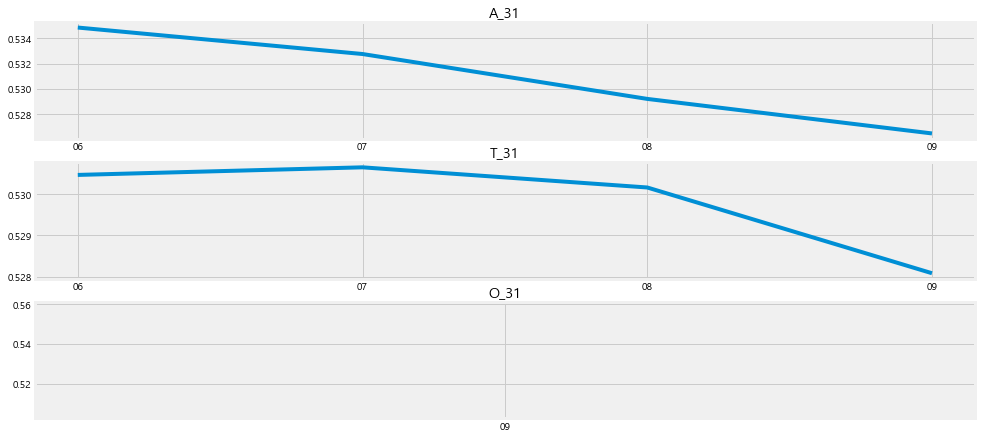

In [54]:
# PRODUCT_CODE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train['PRODUCT_CODE'].unique()):
    plt.subplot(len(train.LINE.unique()), 1, i+1)
    tmp = train[train['PRODUCT_CODE']==l]
    tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
    tmp = tmp.groupby('TIMESTAMP').mean()
    plt.plot(tmp.index, tmp['Y_Quality'])
    plt.title(l)
plt.show()

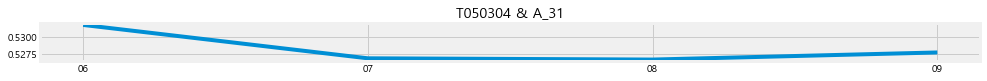

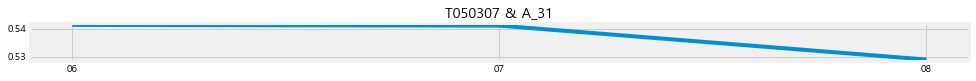

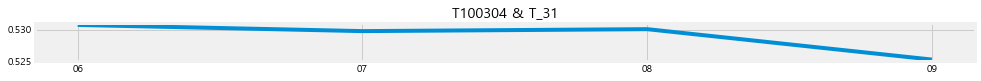

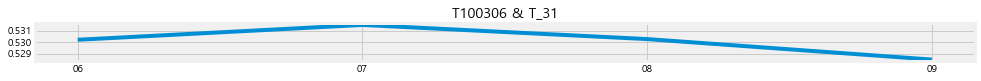

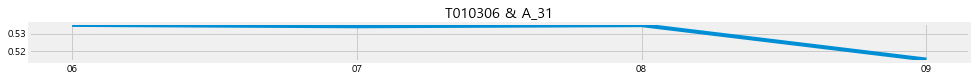

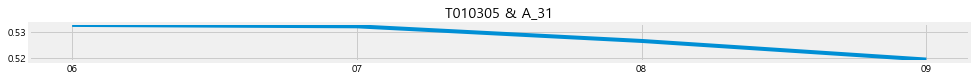

In [55]:
# LINE & PRODUCT_CODE
rcParams['figure.figsize'] = 15, 15

for i, l in enumerate(train.LINE.unique()):
    for i, c in enumerate(['A_31', 'T_31']): # O_31은 표본이 너무 적어 제외
        tmp = train[(train['PRODUCT_CODE']==c)&(train['LINE']==l)]
        if len(tmp) == 0: continue
        plt.subplot(len(train.LINE.unique())*len(train.PRODUCT_CODE.unique()), 1, i+1)
        tmp['TIMESTAMP'] = pd.to_datetime(tmp['TIMESTAMP']).dt.strftime('%m')
        tmp = tmp.groupby('TIMESTAMP').mean()
        plt.plot(tmp.index, tmp['Y_Quality'])
        plt.title(f'{l} & {c}')
    plt.show()

In [56]:
# 월별 영향력이 있어보인다.
train['TIMESTAMP'] = pd.to_datetime(train['TIMESTAMP']).dt.strftime('%m')
train['TIMESTAMP'] = train['TIMESTAMP'].astype('int64')
train.head()

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,6,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,6,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,6,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,6,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN


### X_1 ~ X_2875

In [57]:
len(train.columns)

2881

#### Product Code & Line에 따라 분류했을 경우

In [58]:
train_A1 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050304')]
train_A2 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T050307')]
train_A3 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010306')]
train_A4 = train[(train['PRODUCT_CODE'] == 'A_31') & (train['LINE'] == 'T010305')]
train_T1 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100304')]
train_T2 = train[(train['PRODUCT_CODE'] == 'T_31') & (train['LINE'] == 'T100306')]
train_O1 = train[train['PRODUCT_CODE'] == 'O_31']

In [59]:
print(len(train_A1))
print(len(train_A2))
print(len(train_A3))
print(len(train_A4))
print(len(train_T1))
print(len(train_T2))
print(len(train_O1))

78
42
70
59
172
171
6


In [60]:
# 결측치가 5% 이상이면 제거
def remove_col(df):
    for x in df.columns[6:]:
        if len(df[df[x].isnull()]) > len(df)*0.05:
            df.drop(columns=[x], inplace=True)
    return df

In [61]:
train_A1 = remove_col(train_A1)
train_A2 = remove_col(train_A2)
train_A3 = remove_col(train_A3)
train_A4 = remove_col(train_A4)
train_T1 = remove_col(train_T1)
train_T2 = remove_col(train_T2)
train_O1 = remove_col(train_O1)

In [62]:
print(len(train_A1.columns))
print(len(train_A2.columns))
print(len(train_A3.columns))
print(len(train_A4.columns))
print(len(train_T1.columns))
print(len(train_T2.columns))
print(len(train_O1.columns))

1446
1457
877
877
662
662
656


In [63]:
# 결측값 대체
def nan_replace(df):
    for x in df.columns[6:]:
        for i in df[df[x].isnull()].index:
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==df['TIMESTAMP'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]-1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i]) & (df['TIMESTAMP']==(df['TIMESTAMP'][i]+1))][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue
            m = np.mean(df[(df['Y_Class']==df['Y_Class'][i]) & (df['LINE']==df['LINE'][i])][x])
            if str(m) != 'nan':
                df[x][i] = m
                continue

            df[x][i] = np.mean(df[df['Y_Class']==df['Y_Class'][i]][x])
    return df

In [64]:
train_A1 = nan_replace(train_A1)
train_A2 = nan_replace(train_A2)
train_A3 = nan_replace(train_A3)
train_A4 = nan_replace(train_A4)
train_T1 = nan_replace(train_T1)
train_T2 = nan_replace(train_T2)
train_O1 = nan_replace(train_O1)

In [65]:
train_A1.reset_index(drop=True, inplace=True)
train_A2.reset_index(drop=True, inplace=True)
train_A3.reset_index(drop=True, inplace=True)
train_A4.reset_index(drop=True, inplace=True)
train_T1.reset_index(drop=True, inplace=True)
train_T2.reset_index(drop=True, inplace=True)
train_O1.reset_index(drop=True, inplace=True)

In [66]:
# 상관계수 0.95 이상이면 제거
def corr_drop(train_df):
    tmp = train_df[train_df.columns[2:]].corr()
    for e, c in enumerate(tmp.columns):
        for i in range(e+1, len(tmp.columns)):
            if abs(tmp[c][i]) >= 0.9 and tmp.columns[i] in train_df.columns:
                train_df.drop(columns=[tmp.columns[i]], inplace=True)
    return train_df

In [67]:
train_A1 = corr_drop(train_A1)
train_A2 = corr_drop(train_A2)
train_A3 = corr_drop(train_A3)
train_A4 = corr_drop(train_A4)
train_T1 = corr_drop(train_T1)
train_T2 = corr_drop(train_T2)
train_O1 = corr_drop(train_O1)

In [68]:
print(len(train_A1.columns))
print(len(train_A2.columns))
print(len(train_A3.columns))
print(len(train_A4.columns))
print(len(train_T1.columns))
print(len(train_T2.columns))
print(len(train_O1.columns))

832
809
539
520
442
442
219


In [69]:
# nunique == 1 인 column 제거. ex) LINE, PRODUCT_CODE, x_??
def del_same_value(train_df):
    for c in train_df.columns:
        if train_df[c].nunique() == 1:
            train_df.drop(columns=[c], inplace=True)
    return train_df

In [70]:
train_A1 = del_same_value(train_A1)
train_A2 = del_same_value(train_A2)
train_A3 = del_same_value(train_A3)
train_A4 = del_same_value(train_A4)
train_T1 = del_same_value(train_T1)
train_T2 = del_same_value(train_T2)
train_O1 = del_same_value(train_O1)

### Over Sampling

#### oversampling 이전, 전처리

In [71]:
train_A1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A2.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A3.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_A4.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_T1.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_T2.drop(columns=['PRODUCT_ID', 'Y_Quality'], inplace=True)
train_O1.drop(columns=['LINE', 'PRODUCT_ID', 'Y_Quality'], inplace=True)

In [72]:
def Borderline_SMOTE(train_df):
    B_SMOTE = BorderlineSMOTE(random_state=0)
    x_b_smote, y_b_smote = B_SMOTE.fit_resample(train_df[train_df.columns[1:]], train_df['Y_Class'])
    train_df = x_b_smote
    train_df['Y_Class'] = y_b_smote
    
    return train_df

In [75]:
train_A1 = Borderline_SMOTE(train_A1)
train_A2 = Borderline_SMOTE(train_A2)
train_A3 = Borderline_SMOTE(train_A3)
train_A4 = Borderline_SMOTE(train_A4)
train_T1 = Borderline_SMOTE(train_T1)
train_T2 = Borderline_SMOTE(train_T2)
# train_O1 = Borderline_SMOTE(train_O1) # train_O1은 표본이 6개로 너무 적어서 smote를 이용할 수 없음

In [ ]:
# def ADASYN_(train_df):
#     adasyn = ADASYN(random_state=0)
#     x_adasyn, y_adasyn = adasyn.fit_resample(train_df[train_df.columns[3:]], train_df['Y_Class'])

#     train_df = x_adasyn
#     train_df['Y_Class'] = y_adasyn
#     return train_df

### test data

In [85]:
test = test[test.columns[1:]]

test['TIMESTAMP'] = pd.to_datetime(test['TIMESTAMP']).dt.strftime('%m').astype('int64')
test['LINE'] = test['LINE'].astype('category')
test['PRODUCT_CODE'] = test['PRODUCT_CODE'].astype('category')

test.head()

,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,X_7,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,9,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,51.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,9,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Optuna

In [97]:
kfold = StratifiedKFold(n_splits=5, shuffle=True)

def lgbm_objective(trial):

    params = {
            "objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'boost_from_average' : True
        }

    clf = lightgbm.LGBMClassifier(**params)
    
    f1_list = []
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train, y_train)):
        x_trn, x_val, y_trn, y_val = x_train.loc[train_index], x_train.loc[val_index], y_train.loc[train_index], y_train.loc[val_index]
        clf.fit(x_trn, y_trn)
        f1_list.append(f1_score(clf.predict(x_val), y_val, average='macro'))    
    
    return np.mean(f1_list)

In [98]:
study_list = []
code_line = [['A_31', 'T100304'], ['A_31', 'T050307'], ['A_31', 'T010306'], ['A_31', 'T010305'], ['T_31', 'T100304'], ['T_31', 'T100306']]

for cl, train_df in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2]):
    
    # split
    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    # optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(lgbm_objective, n_trials=200, show_progress_bar=True)

    clear_output(wait=True)
    study_list.append(study)

[I 2023-02-07 02:43:04,452] A new study created in memory with name: no-name-3309bf00-2281-404b-87c4-e9d7bde8909d


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-02-07 02:43:05,126] Trial 0 finished with value: 0.9279689058996631 and parameters: {'max_depth': 410, 'num_leaves': 40, 'learning_rate': 0.8572558714371492, 'n_estimators': 600, 'colsample_bytree': 0.589076506529217, 'colsample_bynode': 0.6924166841709076, 'reg_lambda': 0.01004031480401374, 'reg_alpha': 0.40341964876561787, 'min_child_weight': 15, 'min_child_samples': 58}. Best is trial 0 with value: 0.9279689058996631.
[I 2023-02-07 02:43:05,455] Trial 1 finished with value: 0.9444555895362576 and parameters: {'max_depth': 456, 'num_leaves': 544, 'learning_rate': 0.8160463213362679, 'n_estimators': 100, 'colsample_bytree': 0.9643051527955568, 'colsample_bynode': 0.8416941307304717, 'reg_lambda': 0.04109258927287876, 'reg_alpha': 0.5302210185383578, 'min_child_weight': 10, 'min_child_samples': 67}. Best is trial 1 with value: 0.9444555895362576.
[I 2023-02-07 02:43:08,001] Trial 2 finished with value: 0.9511281597894838 and parameters: {'max_depth': 204, 'num_leaves': 16, 'lea

[I 2023-02-07 02:43:46,482] Trial 19 finished with value: 0.9747116358958813 and parameters: {'max_depth': 94, 'num_leaves': 399, 'learning_rate': 0.3017570279358279, 'n_estimators': 700, 'colsample_bytree': 0.5053279002375521, 'colsample_bynode': 0.5640369526770761, 'reg_lambda': 0.012260248585189782, 'reg_alpha': 0.08535208983706132, 'min_child_weight': 7, 'min_child_samples': 28}. Best is trial 6 with value: 0.9793374577545115.
[I 2023-02-07 02:43:48,898] Trial 20 finished with value: 0.9676554223368854 and parameters: {'max_depth': 63, 'num_leaves': 672, 'learning_rate': 0.08904918092755111, 'n_estimators': 1700, 'colsample_bytree': 0.848086425260539, 'colsample_bynode': 0.6710739125564307, 'reg_lambda': 0.024162229770260543, 'reg_alpha': 0.950480362985604, 'min_child_weight': 12, 'min_child_samples': 79}. Best is trial 6 with value: 0.9793374577545115.
[I 2023-02-07 02:43:51,775] Trial 21 finished with value: 0.9630077043377975 and parameters: {'max_depth': 256, 'num_leaves': 230,

[I 2023-02-07 02:44:17,430] Trial 38 finished with value: 0.9814401308870533 and parameters: {'max_depth': 360, 'num_leaves': 26, 'learning_rate': 0.0754828663528265, 'n_estimators': 300, 'colsample_bytree': 0.6699707487325688, 'colsample_bynode': 0.8659018818323967, 'reg_lambda': 0.25224586331470517, 'reg_alpha': 0.014900685636727112, 'min_child_weight': 3, 'min_child_samples': 65}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:44:17,718] Trial 39 finished with value: 0.9367775269808453 and parameters: {'max_depth': 377, 'num_leaves': 23, 'learning_rate': 0.9091813685244333, 'n_estimators': 200, 'colsample_bytree': 0.6527627827396587, 'colsample_bynode': 0.9387098375809803, 'reg_lambda': 0.22833327702945003, 'reg_alpha': 0.06516690983510343, 'min_child_weight': 6, 'min_child_samples': 64}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:44:18,389] Trial 40 finished with value: 0.9653809101681998 and parameters: {'max_depth': 413, 'num_leaves': 13,

[I 2023-02-07 02:44:51,447] Trial 57 finished with value: 0.9745944496155812 and parameters: {'max_depth': 389, 'num_leaves': 467, 'learning_rate': 0.20243606593479563, 'n_estimators': 1400, 'colsample_bytree': 0.7366072029494184, 'colsample_bynode': 0.7325855481766999, 'reg_lambda': 0.03750713067114625, 'reg_alpha': 0.05817345980480479, 'min_child_weight': 4, 'min_child_samples': 61}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:44:53,299] Trial 58 finished with value: 0.9608319125769864 and parameters: {'max_depth': 481, 'num_leaves': 104, 'learning_rate': 0.359111283384545, 'n_estimators': 1700, 'colsample_bytree': 0.7013818354537787, 'colsample_bynode': 0.9997212731711964, 'reg_lambda': 0.09390069366868381, 'reg_alpha': 0.07181801827154312, 'min_child_weight': 3, 'min_child_samples': 75}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:44:54,865] Trial 59 finished with value: 0.9745596997920247 and parameters: {'max_depth': 108, 'num_leaves': 

[I 2023-02-07 02:45:29,770] Trial 76 finished with value: 0.9512945656918095 and parameters: {'max_depth': 433, 'num_leaves': 151, 'learning_rate': 0.1054918750136993, 'n_estimators': 1400, 'colsample_bytree': 0.7160779777662793, 'colsample_bynode': 0.7560556743071647, 'reg_lambda': 0.3866174250317017, 'reg_alpha': 0.022097083471988743, 'min_child_weight': 6, 'min_child_samples': 82}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:45:31,046] Trial 77 finished with value: 0.970093805524917 and parameters: {'max_depth': 186, 'num_leaves': 788, 'learning_rate': 0.06578130717222874, 'n_estimators': 600, 'colsample_bytree': 0.5818837333046829, 'colsample_bynode': 0.7218635677109677, 'reg_lambda': 0.029103541339954995, 'reg_alpha': 0.02712599870366195, 'min_child_weight': 5, 'min_child_samples': 67}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:45:32,203] Trial 78 finished with value: 0.9650020069351101 and parameters: {'max_depth': 40, 'num_leaves': 4

[I 2023-02-07 02:46:15,634] Trial 95 finished with value: 0.9769507641961728 and parameters: {'max_depth': 128, 'num_leaves': 378, 'learning_rate': 0.27342424542897587, 'n_estimators': 2400, 'colsample_bytree': 0.5535027623598042, 'colsample_bynode': 0.8983832812878596, 'reg_lambda': 0.023359510932385228, 'reg_alpha': 0.2264852436294979, 'min_child_weight': 6, 'min_child_samples': 38}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:46:18,738] Trial 96 finished with value: 0.976760403834445 and parameters: {'max_depth': 282, 'num_leaves': 222, 'learning_rate': 0.5167124083052448, 'n_estimators': 2800, 'colsample_bytree': 0.7544178157026408, 'colsample_bynode': 0.7868026854335176, 'reg_lambda': 0.5784681345095731, 'reg_alpha': 0.019305407826943965, 'min_child_weight': 3, 'min_child_samples': 26}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:46:20,810] Trial 97 finished with value: 0.9792939977061297 and parameters: {'max_depth': 176, 'num_leaves': 

[I 2023-02-07 02:46:54,120] Trial 114 finished with value: 0.972364384050984 and parameters: {'max_depth': 435, 'num_leaves': 366, 'learning_rate': 0.17254381756948575, 'n_estimators': 1600, 'colsample_bytree': 0.6895972646834482, 'colsample_bynode': 0.7284694728458402, 'reg_lambda': 0.03429185414044576, 'reg_alpha': 0.014961407362111066, 'min_child_weight': 5, 'min_child_samples': 71}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:46:55,220] Trial 115 finished with value: 0.9770403409654078 and parameters: {'max_depth': 403, 'num_leaves': 10, 'learning_rate': 0.057832270091043095, 'n_estimators': 600, 'colsample_bytree': 0.6349949698641215, 'colsample_bynode': 0.7450417420486019, 'reg_lambda': 0.35618134617547637, 'reg_alpha': 0.026217140309005908, 'min_child_weight': 4, 'min_child_samples': 69}. Best is trial 22 with value: 0.9837751299595711.
[I 2023-02-07 02:46:58,411] Trial 116 finished with value: 0.9701011854326322 and parameters: {'max_depth': 18, 'num_leave

[I 2023-02-07 02:47:28,622] Trial 133 finished with value: 0.979312567386558 and parameters: {'max_depth': 161, 'num_leaves': 51, 'learning_rate': 0.22094783704633558, 'n_estimators': 2300, 'colsample_bytree': 0.6324220919579153, 'colsample_bynode': 0.84668000218608, 'reg_lambda': 0.3392432882838545, 'reg_alpha': 0.02064560445290869, 'min_child_weight': 2, 'min_child_samples': 54}. Best is trial 120 with value: 0.9838238934566107.
[I 2023-02-07 02:47:31,251] Trial 134 finished with value: 0.9746856043257545 and parameters: {'max_depth': 157, 'num_leaves': 64, 'learning_rate': 0.048564037952432054, 'n_estimators': 2000, 'colsample_bytree': 0.6288325031386857, 'colsample_bynode': 0.852686311415336, 'reg_lambda': 0.34186499676907206, 'reg_alpha': 0.07416408507504046, 'min_child_weight': 3, 'min_child_samples': 53}. Best is trial 120 with value: 0.9838238934566107.
[I 2023-02-07 02:47:33,119] Trial 135 finished with value: 0.9793081141627278 and parameters: {'max_depth': 113, 'num_leaves':

[I 2023-02-07 02:48:07,007] Trial 152 finished with value: 0.9792933897161648 and parameters: {'max_depth': 183, 'num_leaves': 31, 'learning_rate': 0.24990516718223388, 'n_estimators': 2500, 'colsample_bytree': 0.6449996461955309, 'colsample_bynode': 0.7619653726091546, 'reg_lambda': 0.4516463991789552, 'reg_alpha': 0.023248489388008962, 'min_child_weight': 2, 'min_child_samples': 47}. Best is trial 120 with value: 0.9838238934566107.
[I 2023-02-07 02:48:10,017] Trial 153 finished with value: 0.9700398913224081 and parameters: {'max_depth': 219, 'num_leaves': 38, 'learning_rate': 0.24576975749064853, 'n_estimators': 2500, 'colsample_bytree': 0.8953403924768373, 'colsample_bynode': 0.8920705721165239, 'reg_lambda': 0.31412089775939983, 'reg_alpha': 0.024736763834065745, 'min_child_weight': 3, 'min_child_samples': 5}. Best is trial 120 with value: 0.9838238934566107.
[I 2023-02-07 02:48:12,508] Trial 154 finished with value: 0.9677832924466466 and parameters: {'max_depth': 143, 'num_leav

[I 2023-02-07 02:48:45,903] Trial 171 finished with value: 0.9747206899446791 and parameters: {'max_depth': 99, 'num_leaves': 85, 'learning_rate': 0.11735598592479178, 'n_estimators': 1600, 'colsample_bytree': 0.6252350947997238, 'colsample_bynode': 0.8094134357846599, 'reg_lambda': 0.01255034979175376, 'reg_alpha': 0.01413376534071233, 'min_child_weight': 4, 'min_child_samples': 64}. Best is trial 160 with value: 0.9861958053840303.
[I 2023-02-07 02:48:47,778] Trial 172 finished with value: 0.9768417477270204 and parameters: {'max_depth': 292, 'num_leaves': 75, 'learning_rate': 0.13499552463151387, 'n_estimators': 1700, 'colsample_bytree': 0.6034863810931049, 'colsample_bynode': 0.8543638400177092, 'reg_lambda': 0.10309705163648662, 'reg_alpha': 0.021355241758899867, 'min_child_weight': 3, 'min_child_samples': 69}. Best is trial 160 with value: 0.9861958053840303.
[I 2023-02-07 02:48:49,987] Trial 173 finished with value: 0.9744047728252404 and parameters: {'max_depth': 206, 'num_leav

[I 2023-02-07 02:49:28,440] Trial 190 finished with value: 0.983891213631931 and parameters: {'max_depth': 137, 'num_leaves': 18, 'learning_rate': 0.12270272569827909, 'n_estimators': 2100, 'colsample_bytree': 0.6546609735555776, 'colsample_bynode': 0.8598372331075215, 'reg_lambda': 0.04228842146240562, 'reg_alpha': 0.021982185459046896, 'min_child_weight': 2, 'min_child_samples': 26}. Best is trial 160 with value: 0.9861958053840303.
[I 2023-02-07 02:49:31,105] Trial 191 finished with value: 0.9746229229503083 and parameters: {'max_depth': 148, 'num_leaves': 18, 'learning_rate': 0.12156008119939875, 'n_estimators': 2100, 'colsample_bytree': 0.6523555484555019, 'colsample_bynode': 0.8477070712893915, 'reg_lambda': 0.06478210007250679, 'reg_alpha': 0.023452003850334448, 'min_child_weight': 2, 'min_child_samples': 14}. Best is trial 160 with value: 0.9861958053840303.
[I 2023-02-07 02:49:33,570] Trial 192 finished with value: 0.9838553253118452 and parameters: {'max_depth': 130, 'num_lea

In [99]:
def lgbm_objective_O_31(trial):

    params = {
            #"objective": "classifier",
            "n_jobs": 4,
            "max_depth": trial.suggest_int("max_depth", 4, 512),
            'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1, log=True), 
            "learning_rate": trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int("n_estimators", 100, 3000, step=100),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "colsample_bynode": trial.suggest_float("colsample_bynode", 0.5, 1.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1), 
            'min_child_weight': trial.suggest_int('min_child_weight', 2, 15),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        }

    clf = lightgbm.LGBMClassifier(**params)
    clf.fit(x_train, y_train)

    return f1_score(clf.predict(x_train), y_train, average='micro')

x_train = train_O1.drop(columns=['Y_Class'])
y_train = train_O1['Y_Class']

study = optuna.create_study(direction='maximize')
study.optimize(lgbm_objective_O_31, n_trials=50, show_progress_bar=True)

clear_output(wait=True)
study_list.append(study)

[I 2023-02-07 02:49:50,977] A new study created in memory with name: no-name-1c9ca1e1-353e-4ebe-b673-975f0ec3f2ba


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2023-02-07 02:49:51,004] Trial 0 finished with value: 0.6666666666666666 and parameters: {'max_depth': 455, 'num_leaves': 5, 'learning_rate': 0.7097650351550419, 'n_estimators': 600, 'colsample_bytree': 0.7395563797038298, 'colsample_bynode': 0.7636928861945536, 'reg_lambda': 0.04591308559983554, 'reg_alpha': 0.527715967902021, 'min_child_weight': 10, 'min_child_samples': 47}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-07 02:49:51,018] Trial 1 finished with value: 0.6666666666666666 and parameters: {'max_depth': 259, 'num_leaves': 436, 'learning_rate': 0.7150620262557469, 'n_estimators': 1000, 'colsample_bytree': 0.8591199088433066, 'colsample_bynode': 0.9857367945531872, 'reg_lambda': 0.11387343582561871, 'reg_alpha': 0.013176675118624671, 'min_child_weight': 8, 'min_child_samples': 70}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-07 02:49:51,025] Trial 2 finished with value: 0.6666666666666666 and parameters: {'max_depth': 495, 'num_leaves': 56, 'lea

[I 2023-02-07 02:49:51,392] Trial 20 finished with value: 0.6666666666666666 and parameters: {'max_depth': 340, 'num_leaves': 4, 'learning_rate': 0.8351519850925698, 'n_estimators': 600, 'colsample_bytree': 0.6316131726101574, 'colsample_bynode': 0.8412275582789662, 'reg_lambda': 0.012759786102423022, 'reg_alpha': 0.4437984712120507, 'min_child_weight': 5, 'min_child_samples': 47}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-07 02:49:51,415] Trial 21 finished with value: 0.6666666666666666 and parameters: {'max_depth': 444, 'num_leaves': 13, 'learning_rate': 0.5614406296823735, 'n_estimators': 1300, 'colsample_bytree': 0.7269282219688723, 'colsample_bynode': 0.7699035164341864, 'reg_lambda': 0.0220346232808397, 'reg_alpha': 0.5720877339600058, 'min_child_weight': 10, 'min_child_samples': 47}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-07 02:49:51,451] Trial 22 finished with value: 0.6666666666666666 and parameters: {'max_depth': 102, 'num_leaves': 74, 'le

[I 2023-02-07 02:49:52,071] Trial 42 finished with value: 0.6666666666666666 and parameters: {'max_depth': 5, 'num_leaves': 12, 'learning_rate': 0.924658617313715, 'n_estimators': 2700, 'colsample_bytree': 0.541877573301502, 'colsample_bynode': 0.7545358997906093, 'reg_lambda': 0.5130280618117474, 'reg_alpha': 0.2828176090909442, 'min_child_weight': 14, 'min_child_samples': 41}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-07 02:49:52,101] Trial 43 finished with value: 0.6666666666666666 and parameters: {'max_depth': 29, 'num_leaves': 42, 'learning_rate': 0.9863631517180691, 'n_estimators': 2100, 'colsample_bytree': 0.60814897497253, 'colsample_bynode': 0.6379491012833738, 'reg_lambda': 0.3589000907226952, 'reg_alpha': 0.3372522036261411, 'min_child_weight': 14, 'min_child_samples': 17}. Best is trial 0 with value: 0.6666666666666666.
[I 2023-02-07 02:49:52,127] Trial 44 finished with value: 0.6666666666666666 and parameters: {'max_depth': 460, 'num_leaves': 18, 'learning

In [100]:
print()
f1_list = []

for study in study_list:
    trial = study.best_trial

    print("  f1_score : {}".format(trial.value))
    f1_list.append(trial.value)
#    print("  Best hyperparameters: ")
#    for key, value in trial.params.items():
#        print("    {}: {}".format(key, value))
print()
print(f'mean_f1 : {np.mean(f1_list)}')


  f1_score : 0.8765883789413202
  f1_score : 0.9865319865319865
  f1_score : 0.8446459096459096
  f1_score : 0.846092796092796
  f1_score : 0.9695624949340023
  f1_score : 0.9861958053840303
  f1_score : 0.6666666666666666

mean_f1 : 0.8823262911709587


In [106]:
f1_list = []
for train_df, study in zip([train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1], study_list):
    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(x_train, y_train, verbose=0)
    f1 = f1_score(clf.predict(x_train), y_train, average='macro')
    f1_list.append(f1)
    print(f1)
print()
print(np.mean(f1_list))

1.0
1.0
0.9818518518518519
1.0
1.0
1.0
0.4

0.9116931216931218


In [101]:
for study in study_list:
    print(study.best_params)
    print()
    
param_list = []
for cl, train_df, study in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1], study_list):

    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    if cl[0] == 'O_31':
        test_cl = test[test['PRODUCT_CODE'] == cl[0]]
    else:
        test_cl = test[(test['PRODUCT_CODE'] == cl[0]) & (test['LINE'] == cl[1])]
    
    if len(test_cl) == 0:
        continue
    test_cl = test_cl[x_train.columns]
    
    # lightgbm
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(x_train, y_train, verbose=0)
    pred = clf.predict(test_cl)
    for i, idx in enumerate(test_cl.index):
        subm['Y_Class'][idx] = pred[i]

{'max_depth': 45, 'num_leaves': 204, 'learning_rate': 0.2860813359539121, 'n_estimators': 600, 'colsample_bytree': 0.6498514134137433, 'colsample_bynode': 0.9787668366220176, 'reg_lambda': 0.020673981172778015, 'reg_alpha': 0.03991796078216946, 'min_child_weight': 3, 'min_child_samples': 10}

{'max_depth': 361, 'num_leaves': 16, 'learning_rate': 0.1480858780696379, 'n_estimators': 400, 'colsample_bytree': 0.8236855462610295, 'colsample_bynode': 0.585393900958277, 'reg_lambda': 0.02954263422649153, 'reg_alpha': 0.135208407834378, 'min_child_weight': 3, 'min_child_samples': 15}

{'max_depth': 28, 'num_leaves': 236, 'learning_rate': 0.05092409006522597, 'n_estimators': 1900, 'colsample_bytree': 0.6472610798612553, 'colsample_bynode': 0.567668628635469, 'reg_lambda': 0.04453322574780922, 'reg_alpha': 0.028006169244883836, 'min_child_weight': 9, 'min_child_samples': 41}

{'max_depth': 193, 'num_leaves': 33, 'learning_rate': 0.6378988494778889, 'n_estimators': 2900, 'colsample_bytree': 0.542

In [102]:
code_line = [['A_31', 'T100304'], ['A_31', 'T050307'], ['A_31', 'T010306'], ['A_31', 'T010305'], ['T_31', 'T100304'], ['T_31', 'T100306'], ['O_31']]
for cl, train_df, study in zip(code_line, [train_A1, train_A2, train_A3, train_A4, train_T1, train_T2, train_O1], study_list):

    x_train = train_df.drop(columns=['Y_Class'])
    y_train = train_df['Y_Class']
    
    if cl[0] == 'O_31':
        test_cl = test[test['PRODUCT_CODE'] == cl[0]]
    else:
        test_cl = test[(test['PRODUCT_CODE'] == cl[0]) & (test['LINE'] == cl[1])]
    
    if len(test_cl) == 0:
        continue
    test_cl = test_cl[x_train.columns]
    
    # lightgbm
    clf = lightgbm.LGBMClassifier(**study.best_params)
    clf.fit(x_train, y_train, verbose=0)
    pred = clf.predict(test_cl)
    for i, idx in enumerate(test_cl.index):
        subm['Y_Class'][idx] = pred[i]

In [103]:
subm.Y_Class.value_counts()

1    251
0     38
2     21
Name: Y_Class, dtype: int64

In [104]:
subm.to_csv('submission/submission19.csv', index=False) # optuna_Yclass_blsmote_code_line_macro